# Hands-on: PyTorch Tutorial

Welcome to your first hands-on session! During two hours, we will work on a simple example that illustrates the great capabilities of PyTorch. For this tutorial, only basic Python level is required.


# Outline
- [ 1 - Packages ](#1)
- [ 2 - Basics of PyTorch ](#2)
  - [ 2.1 Initialization](#2.1)
  - [ 2.2 Indexing](#2.2)
  - [ 2.3 Arithmetic operations](#2.3)
  - [ 2.4 Backpropagation](#2.4)
  - [ 2.5 GPU computation](#2.5)
- [ 3 - Task ](#3)
- [ 4 - Datasets ](#4)
- [ 5 - Neural network ](#5)
- [ 6 - Training ](#6)
- [ 7 - Testing ](#7)

<a name="1"></a>
## 1 - Packages

Let's first import the important packages that will be needed for our task:
- [xarray](https://docs.xarray.dev) to load the training/test datasets (in netCDF format).
- [numpy](https://numpy.org/) to manipulate arrays of data.
- [matplotlib](https://matplotlib.org/) to create graphs and visualize our data.
- [pytorch](https://pytorch.org/) to create and optimize our neural network.

In [ ]:
# Importing the packages might take some minutes
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import cycle
from tqdm import tqdm

<a name="2"></a>
## 2 - Basics of PyTorch

PyTorch tensors are similar to Numpy arrays. 
In fact, many methods from Numpy exist for PyTorch tensors as well (e.g., `numpy.zeros` ≡ `torch.zeros`, `numpy.shape` ≡ `torch.shape`).
The main difference is that PyTorch tensors support GPU acceleration.

<a name="2.1"></a>
### 2.1 Initialization
Tensors can be initialized in different ways:
- `torch.Tensor` to create a tensor without assignement:
```python
t = torch.Tensor(3, 4)
```
- `torch.zeros`, `torch.ones`, `torch.rand`, `torch.randn`, `torch.arange` to create a tensor with assignement:
```python
t = torch.ones(3, 4)
```
- `torch.from_numpy` to convert a Numpy array to a tensor:
```python
a = np.ones(3, 4)
t = torch.from_numpy(a)
```

<a name="2.2"></a>
### 2.2 Indexing
Indexing is handled as in Numpy. Values can be accessed by using sets of indices or using slices:

In [ ]:
t = torch.rand(3, 4)
print("\nTensor:\n", t)
print("\nElement 2nd row, 3rd column:", t[1,2])
print("\n2nd column:", t[:,1])

<a name="2.3"></a>
### 2.3 Arithmetic operations
PyTorch supports basic arithmetic operations (e.g., addition) as well as more complex operations (e.g., matrix multiplication).

In [ ]:
t1 = torch.arange(6).reshape(2,3)
t2 = t1.clone()
print("Tensor 1/2:\n", t1)
print("\nAddition:\n", t1 + t2)
print("\nElement-wise product:\n", t1 * t2)
print("\nMatrix multiplication:\n", torch.matmul(t1, t2.T))

<a name="2.4"></a>
### 2.4 Backpropagation
An optimization algorithm such as **gradient descent** requires the gradient of the loss function. Gradients can be efficiently computed by **backpropagating**, i.e., proceeding backwards through the feedforward network from the last layer through to the first.

PyTorch can keep tracks of the operations done on tensors and automatically get the gradients needed for the backpropagation.

This capability is disable by default. It can be enabled by using the `requires_grad_`method.

In [ ]:
t1 = torch.ones(1,3)
print("Does my tensor require gradients?", t1.requires_grad)

t1.requires_grad_(True)
print("Does my tensor require gradients?", t1.requires_grad)

We can build a *computation graph* by performing arithmetic operations and then calculate the gradients with `backward`:

In [ ]:
t1 = torch.ones(1,3, requires_grad=True)
t2 = t1 + 2
t3 = t2 ** 2
t4 = t3.mean()

print("Gradients before back propagation:", t1.grad)
t4.backward()
print("Gradients after back propagation:", t1.grad)

`backward` perfoms a backpropagation on the *computation graph* built up dynamically from the three arithmetic operations:

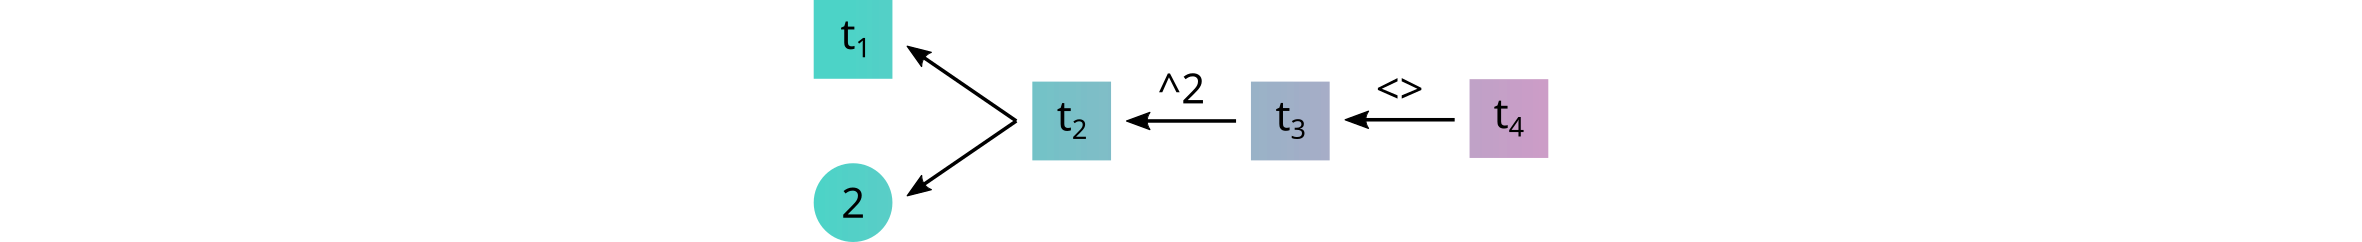

We can check the values of the computed gradients by using the chain rule:
$$
\frac{\partial t_4}{\partial t_1} = \frac{\partial t_4}{\partial t_3}\frac{\partial t_3}{\partial t_2}\frac{\partial t_2}{\partial t_1} = 2
$$

Where:
$$
\frac{\partial t_2}{\partial t_1} = 1
$$
$$
\frac{\partial t_3}{\partial t_2} = 2 * t_2 = 2 * (1 + 2) = 6
$$
$$
\frac{\partial t_4}{\partial t_3} = \frac{1}{3}
$$

<a name="2.5"></a>
### 2.5 GPU computation

By default, all the created tensors are stored on CPUs. However, GPUs are generally more suitable for neural networks as they can perform many thousands of small operations in parallel.

To do so, models and tensors needed for the training have to be pushed to the GPU by using `.to(device)` or `.cuda()`.

In [ ]:
# We first check that the required NVIDIA drivers and CUDA libraries are installed
print("Can I use CUDA?", torch.cuda.is_available())

# If so, we can create an object "device" pointing to the GPU (assuming there is a GPU and CUDA/cuDNN libraries installed):
device = torch.device("cuda")

# It is common to setup the device automatically:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# We can then push a tensor to the GPU:
t = torch.Tensor(3, 4)
print("Is my tensor on the GPU?", t.is_cuda)
t = t.to(device)
print("Is my tensor on the GPU?", t.is_cuda)

<a name="3"></a>
## 3 - Task

Most supervised machine learning algorithms can be categorized as regression or classification.
The main difference between these two types of algorithm is related to the target values:
- continuous for the regression (e.g., prices of apples)
- discrete for the classification (e.g., apple names)

In this session, we want to train a classifier that is able to predict the month corresponding to a specific climate data.
Such task can be applied to many type of climate data (depending on the climate variable, the grid, etc.). In the present case, we are using gridded global temperature anomalies. 

The work will be done following the steps:
- create a training/validation/test dataset from the [20th Century Reanalysis dataset](https://psl.noaa.gov/data/20thC_Rean/)
- create a neural network
- optimize the neural network
- test the trained model on a the test dataset

<a name="4"></a>
## 4 - Datasets

In this section, we will see how to load the 20th Century Reanalysis dataset and split it into training and test datasets. In practice, it is also good to create a validation dataset.

In [ ]:
# We define the absolute path of the file containing the temperature anomalies
path_20cr = "swift://swift.dkrz.de/dkrz_b46b2377-6c24-4ee4-aaf0-cccf0278aae6/mlclass/data/20cr-part.zarr/"
# We load the data into xarray datasets
ds_20cr = xr.open_dataset(path_20cr).load()
ds_20cr

In [ ]:
# We extract the months and create a tensor containing data and labels
def create_dataset(ds):

    n_time, n_lon, n_lat = ds["tas"].shape
    
    targets = torch.empty(n_time, dtype=torch.long)
    for i in range(n_time):
        targets[i] = int(str(ds["time"].values[i]).split("-")[1]) - 1

    dataset = torch.utils.data.TensorDataset(torch.as_tensor(ds["tas"].values.reshape(n_time, 1, n_lon, n_lat)), targets)
    
    return dataset, n_time

data_20cr, n_time = create_dataset(ds_20cr)

In [ ]:
# We use a PyTorch function to split the dataset randomly
n_training = int( n_time * 0.8 )
n_test = n_time - n_training
training_data, test_data = torch.utils.data.random_split(data_20cr, [n_training, n_test])

In [ ]:
# We use another PyTorch function that makes the iteration over the batches of the datasets easier
from torch.utils.data import DataLoader

batch_size = 16

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# We create a function to visualize the data for a given batch
def plot_data(data, labels, predictions=None):
    
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    
    data_shape = data.shape
    
    n_cols = 4
    n_rows = int( np.ceil( data_shape[0] // n_cols ))
    
    x0, y0 = data_shape[2] // 2, data_shape[3] // 2
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,15))
    
    k = 0
    for i in range(n_rows):
        for j in range(n_cols):
            # We get the maximum absolute value of the data to create a symmetric colorbar
            vlim = data[k][0].abs().max()
            axes[i, j].imshow(torch.flip(data[k][0], [0]), cmap="RdBu_r", vmin=-vlim, vmax=vlim)
            axes[i, j].text(x0, y0, months[labels[k].item()], fontsize=15)
            if predictions is not None:
                if predictions[k] == labels[k]:
                    color = "green"
                else:
                    color = "red"
                axes[i, j].text(x0, y0+10, months[predictions[k].item()], fontsize=15, 
                               bbox=dict(facecolor=color, alpha=0.5))
            k += 1
    plt.show()

In [ ]:
# We create an iterator and plot the first batch of samples
dataiter = iter(train_dataloader)
data_batch, labels = next(dataiter)

print("Shape of data batch:", data_batch.shape)
plot_data(data_batch, labels)

<a name="5"></a>
## 5 - Neural network
In this section, we will create a very simple neural network composed of:
- convolutional layers
- max pooling
- fully connected layers

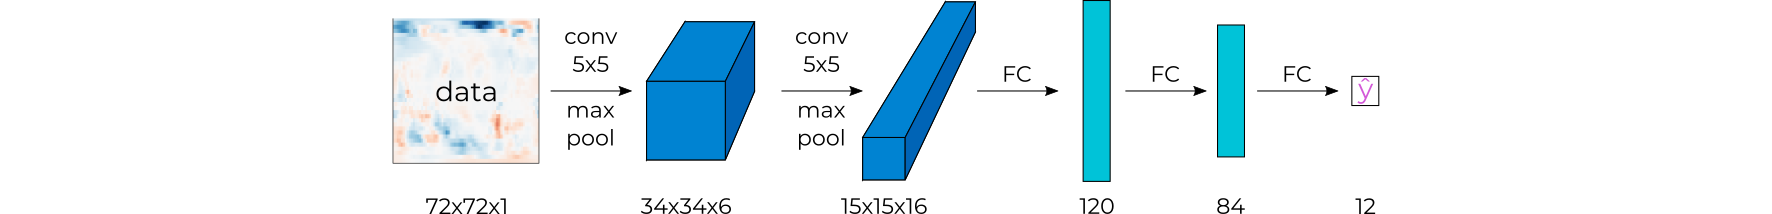

The ouputs of the layer will be activated using a ReLu function.
The optimization will be carried out by using the gradient descent method with a cross entropy loss function.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 15 * 15, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [ ]:
# We define the cross entropy function as our loss function (usual for multi-class classification)
criterion = nn.CrossEntropyLoss()

<a name="6"></a>
## 6 - Training

We can now assemble all the parts defined above and iterate over the samples of the training dataset to optimize the weights and biases in our layers

In [ ]:
def func(data):
        inputs, labels = data


        # We reset the gradients to zero to avoid accumulation over iteration
        optimizer.zero_grad()

        # Forward pass
        model.train() # If we use model.eval() later

        outputs = model(inputs)
        
        # We calculate the loss value
        loss = criterion(outputs, labels)
        
        
        # Backward pass
        loss.backward()

        
        # We update the parameters in the NN
        optimizer.step()


        # We store the training loss value
        train_loss.append(loss.item())


        # In practice, it is good to create a validation dataset
        # and calculate the validation loss as well
        
        model.eval() # Should be used in the general case (turn off batch normalization and dropout layers)

        # We load a new batch of test samples
        inputs, labels = next(dataiter)

        # We temporarily set all the requires_grad flag to false with torch.no_grad()
        with torch.no_grad():
            outputs = model(inputs)

        # We store the validation loss value
        val_loss.append(criterion(outputs, labels))

In [ ]:
# We load the neural network
model = Net()

# We set the optimization algorithm with a learning rate value and a momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Number of times we will go through the whole training dataset
num_epochs = 10

# We create an infinite iterator for the "validation" dataset
dataiter = cycle(test_dataloader)

train_loss = []
val_loss = []
for epoch in tqdm(range(num_epochs)):
    
    for i, data in enumerate(train_dataloader, 0):
        # We load the batch of samples
        func(data)
        break
        
    break
            

print('Done!')


In [ ]:
%%prun
func(data)

In [ ]:
model.conv2?

In [ ]:
n_win = 10
plt.plot(np.convolve(train_loss, np.ones(n_win), "valid")/n_win)
#plt.plot(np.convolve(val_loss, np.ones(n_win), "valid")/n_win)
plt.xlabel("Iterations")
plt.ylabel("Loss")

<a name="7"></a>
## 7 - Testing

In this section, we can compare the accuracy of our trained model on different datasets.

Let's first test our model on the test dataset.

In [ ]:
# We create a function to compute the accuracy given a dataset
def get_score(data_loader, data_type):
    model.eval()
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            # We applied our trained model to each batch of samples
            scores = model(inputs)
            # The shape of scores is (16, 12) = (batch_size, number_of_months)
            # From each sample of the batch (first axis), 
            # get the index of the output with highest value (most probable month)
            _, predictions = scores.max(1)
            num_correct += (predictions == labels).sum()
            num_samples += predictions.size(0)
        print("Accuracy {}: {:.2f}%".format(data_type, 100 * num_correct / num_samples))

In [ ]:
get_score(train_dataloader, "training dataset")
get_score(test_dataloader, "test dataset")

In [ ]:
# We can iterate over different batches of the test dataset and check the predictions
dataiter = iter(test_dataloader)
data_batch, labels = next(dataiter)
_, predictions = model(data_batch).max(1)
plot_data(data_batch, labels, predictions)

Let's try something harder... testing our model on another reanalysis dataset: [ERA-20C](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era-20c)

In [ ]:
# We can use the previously defined functions to load the new dataset
path_era20c = "/work/bk1318/mlclass/data/era20c-part.nc"
data_era20c, _ = create_dataset(xr.open_dataset(path_era20c))
crossval_dataloader = DataLoader(data_era20c, batch_size=batch_size, shuffle=True)

In [ ]:
# The trained model can be applied directly to this new dataset... with less success

get_score(crossval_dataloader, "Cross validation")

dataiter = iter(crossval_dataloader)
data_batch, labels = next(dataiter)
_, predictions = model(data_batch).max(1)
plot_data(data_batch, labels, predictions)